<a href="https://colab.research.google.com/github/Mencch/CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
process_from_drive('/content/drive/MyDrive/side-view-of-a-positive-casual-man-greeting-with-his-hands-wide-open-while-moving-on-white-studio-background-2B3X773.jpg')

In [4]:
!pip install -q opencv-python-headless mediapipe matplotlib numpy pillow


In [5]:
!wget -q -O pose_landmarker_lite.task \
https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_lite/float16/1/pose_landmarker_lite.task


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from google.colab import files, drive
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision


In [8]:
POSE_CONNECTIONS = frozenset([
    (0, 1), (1, 2), (2, 3), (3, 7),
    (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10),
    (11, 12), (11, 13), (13, 15), (15, 17),
    (15, 19), (15, 21), (17, 19),
    (12, 14), (14, 16), (16, 18),
    (16, 20), (16, 22), (18, 20),
    (11, 23), (12, 24), (23, 24),
    (23, 25), (25, 27), (27, 29),
    (29, 31), (27, 31),
    (24, 26), (26, 28), (28, 30),
    (28, 32), (30, 32)
])

def draw_landmarks_on_image(rgb_image, detection_result):
    annotated_image = rgb_image.copy()
    h, w = annotated_image.shape[:2]

    if not detection_result.pose_landmarks:
        return annotated_image

    for landmarks in detection_result.pose_landmarks:
        for start_idx, end_idx in POSE_CONNECTIONS:
            p1 = landmarks[start_idx]
            p2 = landmarks[end_idx]

            cv2.line(
                annotated_image,
                (int(p1.x * w), int(p1.y * h)),
                (int(p2.x * w), int(p2.y * h)),
                (0, 255, 0),
                2
            )

        for lm in landmarks:
            cv2.circle(
                annotated_image,
                (int(lm.x * w), int(lm.y * h)),
                4,
                (0, 0, 255),
                -1
            )

    return annotated_image


In [9]:
class PoseEstimator:
    def __init__(self, model_path='pose_landmarker_lite.task'):
        base_options = python.BaseOptions(model_asset_path=model_path)
        options = vision.PoseLandmarkerOptions(
            base_options=base_options,
            output_segmentation_masks=False,
            min_pose_detection_confidence=0.5,
            min_pose_presence_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.detector = vision.PoseLandmarker.create_from_options(options)

    def process_image(self, image_path):
        image = mp.Image.create_from_file(image_path)
        result = self.detector.detect(image)
        image_np = image.numpy_view()
        annotated = draw_landmarks_on_image(image_np, result)
        return annotated, result

    def calculate_angle(self, p1, p2, p3):
        a = np.array([p1.x, p1.y])
        b = np.array([p2.x, p2.y])
        c = np.array([p3.x, p3.y])

        radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - \
                  np.arctan2(a[1]-b[1], a[0]-b[0])
        angle = abs(radians * 180.0 / np.pi)
        return 360 - angle if angle > 180 else angle

    def analyze_pose(self, result):
        if not result.pose_landmarks:
            print("❌ Դիրք չի հայտնաբերվել")
            return

        lm = result.pose_landmarks[0]

        print("\n===== ԴԻՐՔԻ ՎԵՐԼՈՒԾՈՒԹՅՈՒՆ =====")

        left_arm = self.calculate_angle(lm[11], lm[13], lm[15])
        right_arm = self.calculate_angle(lm[12], lm[14], lm[16])
        left_leg = self.calculate_angle(lm[23], lm[25], lm[27])
        right_leg = self.calculate_angle(lm[24], lm[26], lm[28])

        print(f"Ձախ ձեռք: {left_arm:.1f}°")
        print(f"Աջ ձեռք: {right_arm:.1f}°")
        print(f"Ձախ ոտք: {left_leg:.1f}°")
        print(f"Աջ ոտք: {right_leg:.1f}°")

        visibility = np.mean([l.visibility for l in lm])
        print(f"Վստահություն: {visibility:.2f}")
        print("=" * 35)


In [10]:
def process_from_drive(image_path):
    drive.mount('/content/drive')
    estimator = PoseEstimator()

    original = PILImage.open(image_path)
    annotated, result = estimator.process_image(image_path)

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.title("Սկզբնական նկար")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(annotated)
    plt.title("Դիրքի գնահատում")
    plt.axis("off")
    plt.show()

    estimator.analyze_pose(result)


Mounted at /content/drive


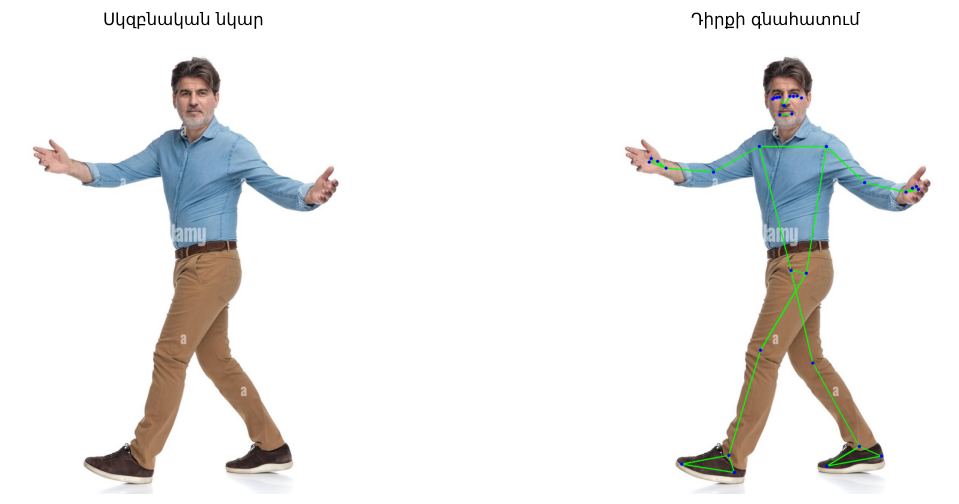


===== ԴԻՐՔԻ ՎԵՐԼՈՒԾՈՒԹՅՈՒՆ =====
Ձախ ձեռք: 153.8°
Աջ ձեռք: 153.2°
Ձախ ոտք: 163.6°
Աջ ոտք: 160.7°
Վստահություն: 0.99


In [11]:
process_from_drive(
    '/content/drive/MyDrive/side-view-of-a-positive-casual-man-greeting-with-his-hands-wide-open-while-moving-on-white-studio-background-2B3X773.jpg'
)
